In [13]:
!pip install transformers datasets
!pip install transformers scikit-learn onnxruntime


import os
import json
import numpy as np
import torch
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import onnxruntime as ort
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


## Mount Google Drive in Colab

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## load validation dataset

In [15]:
validation_path = 'validation.json'  # Update with your actual file path
with open(validation_path, 'r') as f:
    validation_data = json.load(f)

## Import Required Libraries

In [16]:
def tokenize_and_align_labels(text, spans, tokenizer, labels_to_ids):
    tokens = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_offsets_mapping=True
    )
    offset_mapping = tokens["offset_mapping"]
    labels = [labels_to_ids["O"]] * len(offset_mapping)  # Default to "O"

    for span in spans:
        start, end, label = span["start"], span["end"], span["label"]
        for idx, (token_start, token_end) in enumerate(offset_mapping):
            if token_start >= start and token_end <= end:
                labels[idx] = labels_to_ids[label]  # Directly assign the label ID

    tokens.pop("offset_mapping")  # Remove offset mapping
    return tokens, labels

## Load the Tokenizer & Create Custom Dataset Class

In [17]:
model_path = '/content/drive/MyDrive/models/model 1 | 2024-12-26'  # Path to your tokenizer directory
# model_path = '/content/drive/MyDrive/models/model 2 | 2025-01-02'  # Path to your tokenizer directory
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Define the label mapping
labels_to_ids = {
    "O": 0, "HOSP": 1, "PATIENT": 2, "STAFF": 3, "AGE": 4,
    "DATE": 5, "PHONE": 6, "ID": 7, "EMAIL": 8, "LOC": 9, "ORG": 10
}
ids_to_labels = {v: k for k, v in labels_to_ids.items()}

class TokenClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, labels_to_ids):
        self.data = data
        self.tokenizer = tokenizer
        self.labels_to_ids = labels_to_ids

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item["text"]
        spans = item["spans"]
        tokens, labels = tokenize_and_align_labels(text, spans, self.tokenizer, self.labels_to_ids)
        tokens["labels"] = labels  # Keep labels as a list for now
        return {key: torch.tensor(val, dtype=torch.long) if isinstance(val, list) else val for key, val in tokens.items()}

validation_dataset = TokenClassificationDataset(validation_data, tokenizer, labels_to_ids)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)


## Load ONNX Model


In [18]:
onnx_model_path = model_path+'/model.onnx'
session = ort.InferenceSession(onnx_model_path)

## Evaluate the Model

In [19]:
all_labels = []
all_preds = []

for batch in validation_loader:
    input_ids = batch["input_ids"].numpy()
    attention_mask = batch["attention_mask"].numpy()
    token_type_ids = batch["token_type_ids"].numpy()  # Include token_type_ids
    labels = batch["labels"].numpy()

    # ONNX model inference
    outputs = session.run(None, {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids
    })
    logits = outputs[0]
    predictions = np.argmax(logits, axis=-1)

    # Collect predictions and labels for non-padding tokens
    for i in range(len(labels)):
        label = labels[i]
        pred = predictions[i]
        mask = batch["attention_mask"][i].numpy()
        all_labels.extend(label[mask == 1])
        all_preds.extend(pred[mask == 1])

# Convert predictions and labels back to original format
all_labels = [ids_to_labels[label] for label in all_labels]
all_preds = [ids_to_labels[pred] for pred in all_preds]


## Reports

              precision    recall  f1-score   support

         AGE       1.00      1.00      1.00         7
        DATE       1.00      1.00      1.00       153
       EMAIL       1.00      1.00      1.00        76
        HOSP       0.97      0.80      0.88        44
          ID       1.00      1.00      1.00        58
         LOC       1.00      1.00      1.00        37
           O       0.97      1.00      0.98      1796
         ORG       1.00      1.00      1.00        13
     PATIENT       0.98      0.73      0.84       186
       PHONE       1.00      1.00      1.00        87
       STAFF       1.00      0.95      0.97        39

    accuracy                           0.98      2496
   macro avg       0.99      0.95      0.97      2496
weighted avg       0.98      0.98      0.97      2496



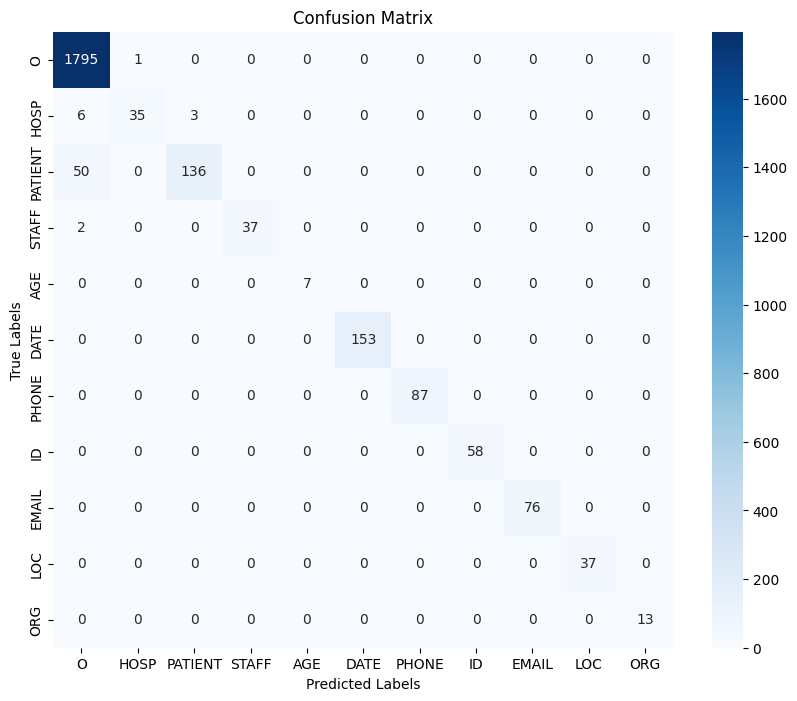

In [20]:
# Calculate Metrics
report = classification_report(all_labels, all_preds, output_dict=False)
print(report)


# Generate confusion matrix
unique_labels = list(labels_to_ids.keys())  # List of all label names
cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
